# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game AI) - Sesión 7 (Tarea)

PhD. Edwin Villanueva, BEng. Daniel Saromo

<font color='orange'>Entorno `GridEnvironment` con aprendizaje por Q-Learning.</font>


El presente desafio aborda la experimentacion de agentes de aprendizaje por refuerzo Q-learning en entornos grid. La implementacion de la clase del entorno GridEnvironment y el agente Q-learning ya estan implementadas. El desafío se encuentra al final del notebook.

Se requiere tener el archivo [`mdp.py`](https://github.com/aimacode/aima-python/blob/master/mdp.py).

###  Clase <b>GridEnvironment</b>

La clase GridEnvironment define un entorno MDP (Proceso de Desiciones de Markov) para entornos grids (laberintos), como el ejemplo usado en clase. Las probabilidades de transicion son 0.8 para moverse en la dirección pretendida y 0.1 de moverse a un estado lateral. El constructor recibe:

- grid: un array de listas de numeros definiendo los rewards del grid del entorno. Valores None indican un obstaculo
- terminals: lista de estados terminales
- initial: estado inicial
- gamma: factor de descuento

La clase mantiene el estado actual (current_state), el cual se inicializa en estado "initial" y se modifica con cada paso que se dé en el entorno (llamada a step()), devolviendo el nuevo estado, el reward y un flag 'done' que indica si el entorno ha caido en un estado terminal. El modelo de transicion de cada estado es accesible a travez de la funcion T(s,a) que devuelve una lista de tuplas (prob, s') para cada estado vecino s' del estado s ejecutando la accion a (prob es la probabilidad de transicionar de s a s' con accion a)

In [2]:
from collections import defaultdict
import random
import operator
import numpy as np

EAST, NORTH, WEST, SOUTH = (1, 0), (0, 1), (-1, 0), (0, -1)
LEFT, RIGHT = +1, -1
        
class GridEnvironment:
    def __init__(self, grid, terminals, initial=(0, 0), gamma=.9):
        grid.reverse()     # para que fila 0 sea la de abajo, no la de arriba
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.grid = grid
        self.initial_state = initial
        self.current_state = initial
        self.terminals = terminals
        self.gamma = gamma
        self.actionlist = [EAST, NORTH, WEST, SOUTH] 

        self.rewards = {}        # diccionario de rewards
        self.states = set()     # conjunto de estados diferentes
        for x in range(self.cols):   # obtiene todos los estados y rewards del grid
            for y in range(self.rows):
                if grid[y][x]:  # Si la celda no es None (Prohibida), agrega el estado y reward
                    self.states.add((x, y))
                    self.rewards[(x, y)] = grid[y][x]
            
        self.transition_probs = {}  # almacena los diccionarios de probabilidades de transicion
        for s in self.states:
            self.transition_probs[s] = {}  # diccionario de probabilidades de transicion de los vecinos de estado s
            for a in self.actionlist:
                self.transition_probs[s][a] = self.get_transition_probs(s, a)
                
    def get_transition_probs(self, state, action): 
        # Hay 0.8 de probabilidad de moverse en la dirección pretendida y 0.1 de moverse por cada lateral. 
        if action:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, self.turn_right(action))),
                    (0.1, self.go(state, self.turn_left(action)))]
        else:
            return [(0.0, state)]
        
    def go(self, state, direction):
        """Retorna el estado que resultaria de ir en la direccion pasada, si el ambiente fuese deterministico """
        state1 = tuple(map(operator.add, state, direction))
        return state1 if state1 in self.states else state    
    
    def turn_heading(self, heading, inc, headings=[EAST, NORTH, WEST, SOUTH]):
        return headings[(headings.index(heading) + inc) % len(headings)]

    def turn_right(self, heading):
        return self.turn_heading(heading, RIGHT)

    def turn_left(self, heading):
        return self.turn_heading(heading, LEFT) 
    
    def T(self, s, a):  # Retorna los estados vecinos y sus prob de transicion, tuplas (prob, s'), para el estado  s y accion a
        return self.transition_probs[s][a] if a else [(0.0, s)]

    def R(self, state): # retorna el reward de un estado
        return self.rewards[state]    
    
    def actions(self, state): # retorna la lista de acciones posibles en un estado 
        if state in self.terminals:
            return [None]
        else:
            return self.actionlist    
    
    def reset(self):  # Reseta el Entorno
        self.current_state = self.initial_state
        return self.current_state, self.rewards[self.current_state]
    
    def step(self, action): # Ejecuta un paso el entorno. Retorna el nuevo estado, el reward y flag de que es estado terminal
        x = random.uniform(0, 1)
        cumulative_probability = 0.0
        for probability_state in self.T(self.current_state, action):
            probability, next_state = probability_state
            cumulative_probability += probability
            if x < cumulative_probability:
                break
        self.current_state = next_state
        done = True if current_state in self.terminals else False
        return self.current_state, self.rewards[self.current_state], done
    
    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""
        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                               for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {(1, 0): '>', (0, 1): '^', (-1, 0): '<', (0, -1): 'v', None: '.'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})
    
    def print_policy(self, policy):
        """Imprime la politica"""
        header=None
        sep='   '
        numfmt='{}'
        table = self.to_arrows(policy)
        justs = ['rjust' if hasattr(x, '__int__') else 'ljust' for x in table[0]]

        if header:
            table.insert(0, header)

        table = [[numfmt.format(x) if hasattr(x, '__int__') else x for x in row]
                 for row in table]

        sizes = list(
            map(lambda seq: max(map(len, seq)),
                list(zip(*[map(str, row) for row in table]))))

        for row in table:
            print(sep.join(getattr(
                str(x), j)(size) for (j, size, x) in zip(justs, sizes, row)))
            

###  Entorno para experimentar </b>
Para experimentar,  se usará el entorno MDP definido abajo. El factor de descuento es $\gamma = 0.9$ (en los ejemplos de clase se usó $\gamma = 1$). Las recompensas son **-0.1** en estados no terminales y **+5** y **-5** en estados terminales.   

In [3]:
# el grid que se vio en clase
#grid = [[-0.04, -0.04, -0.04, +1],
#        [-0.04,  None, -0.04, -1],
#        [-0.04, -0.04, -0.04, -0.04]]

# el grid de este desafio
grid = [
    [None, None, None, None, None, None, None, None, None, None, None], 
    [None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None, +5.0, None], 
    [None, -0.1, None, None, None, None, None, None, None, -0.1, None], 
    [None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None], 
    [None, -0.1, None, None, None, None, None, None, None, None, None], 
    [None, -0.1, None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None], 
    [None, -0.1, None, None, None, None, None, -0.1, None, -0.1, None], 
    [None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None, -0.1, None], 
    [None, None, None, None, None, -0.1, None, -0.1, None, -0.1, None], 
    [None, -5.0, -0.1, -0.1, -0.1, -0.1, None, -0.1, None, -0.1, None], 
    [None, None, None, None, None, None, None, None, None, None, None]
]


## Clase <b>QLearningAgent</b>

Esta clase define un agente exploratorio Q-learning. Este evita aprender el modelo de transicion ya que los Q-valores de un estado-action puede ser relacionado directamente a los Q-valores de los estado-action vecinos 

In [4]:
class QLearningAgent:
    
    def __init__(self, mdp, Ne, Rplus, alpha=None):

        self.gamma = mdp.gamma    # factor de descuento (definido en el MDP)
        self.terminals = mdp.terminals   # estados terminales (definido en el MDP)
        self.all_act = mdp.actionlist  # acciones posibles
        self.Ne = Ne        # limite de iteraciones de la funcion de exploracion
        self.Rplus = Rplus  # Recompensa que tienen los estados (o q-estados) antes del limite de iteraciones Ne
        self.Q = defaultdict(float)   # almacena los q-valores
        self.Nsa = defaultdict(float) # almacena la tabla de frecuencias state-action
        self.s = None    # estado anterior
        self.a = None    # ultima accion ejecutada
        self.r = None    # recompensa de estado anterior

        if alpha:
            self.alpha = alpha   # alpha es la taza de aprendizaje. Debe disminuir con el numero de visitas al estado para que las utilidades converjan
        else:
            self.alpha = lambda n: 1./(1+n)  # udacity video

    def f(self, u, n): 
        """ Funcion de exploracion. Retorna un valor de utilidad fijo (Rplus) hasta que el agente visita Ne veces el state-action """
        if n < self.Ne:
            return self.Rplus
        else:
            return u

    def actions_in_state(self, state):
        """ Retorna el conbjunto de acciones posibles del estado pasado. Util para max y argmax. """
        if state in self.terminals:
            return [None]
        else:
            return self.all_act

    # Programa del agente Q-learning    | CHEQUEAR CON EL SEUDOCÓDIGO DEL PPT
    def __call__(self, percept):    
        """ Este es el programa del agente que es llamado en cada step, recibe un percept y retorna una accion """
        s1, r1 = self.update_state(percept)
        Q, Nsa, s, a, r = self.Q, self.Nsa, self.s, self.a, self.r
        alpha, gamma, terminals = self.alpha, self.gamma, self.terminals,
        actions_in_state = self.actions_in_state

        if s in terminals:
            Q[s, None] = r1
        if s is not None:
            Nsa[s, a] += 1
            Q[s, a] += alpha(Nsa[s, a]) * (r + gamma * max(Q[s1, a1] for a1 in actions_in_state(s1)) - Q[s, a])
        if s in terminals:
            self.s = self.a = self.r = None
        else:
            self.s, self.r = s1, r1
            self.a = max(actions_in_state(s1), key=lambda a1: self.f(Q[s1, a1], Nsa[s1, a1])) # funciona como argmax, devuelve la accion con mayor f

        return self.a

    def update_state(self, percept):
        ''' To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)'''
        return percept

## Probando el agente  <b>Q-learning</b>

Vamos a instanciar un agente Q-learning para aprender una politica en nuestro entorno de prueba "grid". Los parametros del agente son los siguientes: **Ne = 10**, **Rplus = 2**, **alpha** como dado en la nota de pie del libro **pagina 837**:

In [5]:
environment.reset()

NameError: ignored

In [ ]:
# Instancia el entorno del grid
#environment = GridEnvironment(grid, terminals=[(3, 2), (3, 1)], initial=(0, 0), gamma=0.9) # grid de la clase
environment = GridEnvironment(grid, terminals=[(1, 1), (9, 9)], initial=(3, 1), gamma=0.9) # 

# Instancia un agente Q-learning 
agent = QLearningAgent(environment, Ne=10, Rplus=2, alpha=lambda n: 60./(59+n))

# Ejecuta 10000 episodios del agente en el entorno
TRIALS = 4000

training_rewards = []

for e in range(TRIALS):   # Por caa trial
    current_state, current_reward = environment.reset()
    score_trial = current_reward   # el escore del episodio es la suma acumulada de rewards en el episodio 
    while True:  # ejecuta steps del entorno hasta llegar a un estado terminal
        percept = (current_state, current_reward)  # la percepcion del agente es la tupla (state, reward)
        action  = agent(percept)  # llama al programa del agente, pasandole el percept y espera una accion a ejecutar
        current_state, current_reward, done = environment.step(action) # ejecuta la accion en el entorno, 
        score_trial += current_reward
        if done:
            print("Trial: {}/{}, Score: {}".format(e, TRIALS, score_trial))
            training_rewards.append(score_trial)
            break

Ahora veamos el diccionario de los Q-valores aprendidos. Las claves son pares state-action. Las diferentes acciones corresponden a:

NORTH = (0, 1)  
SOUTH = (0,-1)  
WEST = (-1, 0)  
EAST = (1, 0)

In [ ]:
Qvalues = agent.Q


#el 'q' value es el valor float obtenido en el 'defaultDict'
#que se va actualizando con cada exploración según los valores en tupla
#que corresponden a movimientos concretos dados

#para la acción en eoncreto, se elije el valor 'q' mayor (es decir, si son todos negativos
#se elige el más cercano a cero)

print(Qvalues)

In [ ]:
#veamos más claro
agent.Q 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 4.5))

mpl.style.use('classic')

ax.set_title('Rewards acumulados')
ax.set_xlabel("Trials")
ax.set_ylabel("Score (reward acumulado) del trial")
ax.plot(training_rewards,'-', label='reward')
ax.legend(loc='best')

In [ ]:
[60./(59+n)*0.9 for n in range(-3,8)]

## DESAFIO:


<b>1) Cree una funcion para extraer las utilidades (U) de los estados a partir de los Q-valores obtenidos por el agente. LLame esta funcion: get_utilities_from_qvalues(Qvalues). Pruebela en el resultado anterior (agent.Q)</b>


Respuesta:

In [ ]:
def get_utilities_from_qvalues(mdp, Q):
    """Dado un MDP y una funcion de utilidad Q, determina los valores de utilidad de los estados. """
    U = {}
    for s in mdp.states:
        if s not in mdp.terminals:
            U[s] =  -np.inf
            for a in mdp.actionlist:
                if Q[(s, a)] > U[s] : 
                    U[s] = Q[(s, a)]
    return U

In [ ]:
U = get_utilities_from_qvalues(environment, agent.Q)
print(U)

<b>2)  Cree una funcion para extraer la politica a partir de los Q-valores obtenidos por el agente. LLame esta funcion: get_policy_from_qvalues(Qvalues). Pruebela en el resultado anterior (agent.Q)</b>


Respuesta:

In [ ]:
def get_policy_from_qvalues(mdp, Q):
    """Dado un MDP y una funccion de utilidad Q, determina la mejor politica. """
    pi = {}
    for s in mdp.states:
        if s not in mdp.terminals:
            pi[s] = max(mdp.actionlist, key=lambda a: Q[(s,a)])
        else:
            pi[s] = None
    return pi

In [ ]:
pi_qlearning = get_policy_from_qvalues(environment, Qvalues)
environment.print_policy(pi_qlearning)

<b> 3) Cree una función para comparar dos politicas y devolver el numero de estados en que coinciden las politicas. Llame dicha funcion: comparare_policies(policy1, policy2). Pruebe la función con policy1 = pi (la politica obtenida en la pregunta 1) y policy2 = la política optima de resolver el MDP con el metodo value_iteration (1 punto). <b>

In [ ]:
# Computa e imprime la politica optima usando value_iteration (este tiene acceso al modelo de transicion) 
from mdp import *  # mdp tiene la implementacion de value iteration
pi_valueiteration = best_policy(environment, value_iteration(environment, .001))
environment.print_policy(pi_valueiteration)

In [6]:
def comparare_policies(policy1, policy2):
  #función para comprar políticas
  #comprar política "pi_valueiteration"
  #comparar política "pi_qlearning"
  #ver qué acciones coinciden
  #la idea es comprar las políticas
    # TODO:  Esta es la parte que debe completar. Debe devolver el numero de acciones coincidentes entre politicas
    


    

SyntaxError: ignored

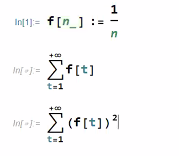

In [ ]:
num_acciones_coincidentes = comparare_policies(pi_qlearning, pi_valueiteration)

<b> 4) Ejecute el agente (10000 trials) con los siguientes valores de `Ne`: {0, 1, 5, 10} y compare las políticas obtenidas en relación a la política óptima de `value_iteration` (`pi_valueiteration`). ¿Cuál valor de `Ne` genera resultados más próximos a la política óptima? (1 punto)<b>